In [2]:
# -*- coding: utf-8 -*-
"""
Created on Mon Mar 29 22:33:23 2021

@authors: Marco, Christian, Lorenzo
"""

import platform
import numpy as np
import math
import sys
from operator import itemgetter
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import requests
import matplotlib
import csv
import json
from pandas.io.json import json_normalize
from networkx.algorithms import community 
import itertools
import re

## Domande di ricerca
Capire se possiamo prevedere a tempo t quanto raccoglierà una determinata impresa a tempo t+1 (t+n) data la conformazione del network <br>
Capire se possiamo prevedere se una startup avrà successo a tempo t+1 o t+n data la conformazione del network (proxy di successo = ha ricevuto finanziamenti)<br>
Capire se ci sono investitori hub e investitori followers <br>
Trovare subgraph similarities all'interno del network

In [3]:
tot = pd.read_excel('Pasadena.xlsx')

In [169]:
tot[tot['Investors']=='NaN']

,Unnamed: 0,Organisation,Funding type,Money raised,Pre-money valuation,Date,Investors,Location,ID,Org_location,...,inv_region,inv_country,inv_city_coo,inv_region_coo,inv_country_coo,USDraised,Date_m-y,CPI,CPI_2000,USDraised_cpi


In [164]:
tot

,Unnamed: 0,Organisation,Funding type,Money raised,Pre-money valuation,Date,Investors,Location,ID,Org_location,...,inv_region,inv_country,inv_city_coo,inv_region_coo,inv_country_coo,USDraised,Date_m-y,CPI,CPI_2000,USDraised_cpi
0,0,Meddy,Series A,"$2,500,000",NaN,2019-10-27,212,"Dubai, Dubai, United Arab Emirates, Asia",6132,"['Dubai', 'Dubai', 'United Arab Emirates', 'As...",...,"Istanbul, Turkey",Turkey,"(41.0096334, 28.9651646)","(41.0096334, 28.9651646)","(38.9597594, 34.9249653)",2.500000e+06,2019-10,257.346,147.900000,1.690331e+06
1,1,Lemonaid Health,Series A,"$11,000,000",NaN,2017-05-22,415,"San Francisco, California, United States, Nort...",18965,"['San Francisco', 'California', 'United States...",...,"California, United States",United States,"(37.7790262, -122.4199061)","(36.7014631, -118.755997)","(39.7837304, -100.4458825)",1.100000e+07,2017-05,244.733,140.651149,7.820768e+06
2,2,Prellis Biologics,Seed,"$1,800,000",NaN,2017-09-13,415,"San Francisco, California, United States, Nort...",17358,"['San Francisco', 'California', 'United States...",...,"California, United States",United States,"(37.7790262, -122.4199061)","(36.7014631, -118.755997)","(39.7837304, -100.4458825)",1.800000e+06,2017-09,246.819,141.850000,1.268946e+06
3,3,Memed,Seed,"R$50,000",NaN,2013-01-01,21212,"SÃ£o Paulo, Sao Paulo, Brazil, South America",37577,"['SÃ£o Paulo', 'Sao Paulo', 'Brazil', 'South A...",...,"Rio de Janeiro, Brazil",Brazil,"(-22.9110137, -43.2093727)","(-22.9110137, -43.2093727)","(-10.3333333, -53.2)",2.461280e+04,2013-01,230.280,132.344828,1.859748e+04
4,4,1859,Venture - Series Unknown,"$7,713,742",NaN,2020-08-11,NaN,"San Diego, California, United States, North Am...",2158,"['San Diego', 'California', 'United States', '...",...,NaN,NaN,NaN,NaN,NaN,7.713742e+06,2020-08,259.918,149.378161,5.163902e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87351,87351,CellScape,Series A,"$1,600,000",NaN,2010-12-01,Zygote Ventures,"Newark, California, United States, North America",42203,"['Newark', 'California', 'United States', 'Nor...",...,"California, United States",United States,"(37.9735346, -122.5310874)","(36.7014631, -118.755997)","(39.7837304, -100.4458825)",1.600000e+06,2010-12,219.179,125.964943,1.270195e+06
87352,87352,BioBeats,Venture - Series Unknown,NaN,NaN,2020-01-01,Zynik Capital Corp.,"London, England, United Kingdom, Europe",5167,"['London', 'England', 'United Kingdom', 'Europe']",...,"British Columbia, Canada",Canada,"(49.2608724, -123.1139529)","(55.001251, -125.002441)","(61.0666922, -107.991707)",NaN,2020-01,257.971,148.259195,NaN
87353,87353,Angiotech Pharmaceuticals,Venture - Series Unknown,NaN,NaN,2017-03-21,ZZ Capital,"Vancouver, British Columbia, Canada, North Ame...",19835,"['Vancouver', 'British Columbia', 'Canada', 'N...",...,"Beijing, China",China,"(39.906217, 116.3912757)","(39.906217, 116.3912757)","(35.000074, 104.999927)",NaN,2017-03,243.801,140.115517,NaN
87354,87354,KIMS Hospitals,Debt Financing,"â‚¹600,000,000",NaN,2017-11-10,Ñ‘people,"Hyderabad, Andhra Pradesh, India, Asia",16513,"['Hyderabad', 'Andhra Pradesh', 'India', 'Asia']",...,"Maharashtra, India",India,"(19.0759899, 72.8773928)","(18.9068356, 75.6741579)","(22.3511148, 78.6677428)",9.251516e+06,2017-11,246.669,141.763793,6.526007e+06


In [171]:
tot[['Organisation', 'org_country', 'org_city_coo']].drop_duplicates()

,Organisation,org_country,org_city_coo
0,Meddy,United Arab Emirates,"(25.0750095, 55.18876088183319)"
1,Lemonaid Health,United States,"(37.7790262, -122.4199061)"
2,Prellis Biologics,United States,"(37.7790262, -122.4199061)"
3,Memed,Brazil,"(-23.5506507, -46.6333824)"
4,1859,United States,"(32.7174202, -117.1627728)"
...,...,...,...
87295,FertilityDost,India,"(28.6138954, 77.2090057)"
87296,Innoweave Biocare,India,"(19.0759899, 72.8773928)"
87298,WeeSure,India,"(28.5707841, 77.3271074)"
87318,Schwarzer Cardiotek,Germany,"(49.142291, 9.218655)"


In [419]:
#%%
nodes_org = tot[['Organisation', 'org_country', 'org_city_coo']].drop_duplicates()
nodes_org['kind'] = 'Target'
nodes_inv = tot[['Investors', 'inv_country', 'inv_city_coo']].drop_duplicates()
nodes_org = nodes_org.rename(columns={"Organisation": "Node", "org_country": "Country", "org_city_coo": "Coo"})
nodes_inv = nodes_inv.rename(columns={"Investors": "Node","inv_country": "Country", "inv_city_coo": "Coo"})
nodes_inv['kind'] = 'Bidder'
nodes = nodes_org.append(nodes_inv, ignore_index= True)
nodes['id'] = nodes.index

,Node,Country,Coo,kind,id,coo,lat,long
0,Meddy,United Arab Emirates,"(25.0750095, 55.18876088183319)",Target,0,"[25.0750095, 55.18876088183319]",25.075010,55.188761
1,Lemonaid Health,United States,"(37.7790262, -122.4199061)",Target,1,"[37.7790262, -122.4199061]",37.779026,-122.419906
2,Prellis Biologics,United States,"(37.7790262, -122.4199061)",Target,2,"[37.7790262, -122.4199061]",37.779026,-122.419906
3,Memed,Brazil,"(-23.5506507, -46.6333824)",Target,3,"[-23.5506507, -46.6333824]",-23.550651,-46.633382
4,1859,United States,"(32.7174202, -117.1627728)",Target,4,"[32.7174202, -117.1627728]",32.717420,-117.162773
...,...,...,...,...,...,...,...,...
40505,ZWC Partners,Hong Kong,"(22.2793278, 114.1628131)",Bidder,40505,"[22.2793278, 114.1628131]",22.279328,114.162813
40506,Zygote Ventures,United States,"(37.9735346, -122.5310874)",Bidder,40506,"[37.9735346, -122.5310874]",37.973535,-122.531087
40507,Zynik Capital Corp.,Canada,"(49.2608724, -123.1139529)",Bidder,40507,"[49.2608724, -123.1139529]",49.260872,-123.113953
40508,ZZ Capital,China,"(39.906217, 116.3912757)",Bidder,40508,"[39.906217, 116.3912757]",39.906217,116.391276


In [193]:
nodes_org2 = tot[['Organisation', 'org_country']].drop_duplicates()
nodes_org2['kind'] = 'Target'
nodes_inv2 = tot[['Investors', 'inv_country']].drop_duplicates()
nodes_org2 = nodes_org2.rename(columns={"Organisation": "Node", "org_country": "Country", "org_city_coo": "Coo"})
nodes_inv2 = nodes_inv2.rename(columns={"Investors": "Node","inv_country": "Country", "inv_city_coo": "Coo"})
nodes_inv2['kind'] = 'Bidder'
nodes2 = nodes_org2.append(nodes_inv2, ignore_index= True)
nodes2['id'] = nodes2.index

In [194]:
nodes2

,Node,Country,kind,id
0,Meddy,United Arab Emirates,Target,0
1,Lemonaid Health,United States,Target,1
2,Prellis Biologics,United States,Target,2
3,Memed,Brazil,Target,3
4,1859,United States,Target,4
...,...,...,...,...
40483,ZWC Partners,Hong Kong,Bidder,40483
40484,Zygote Ventures,United States,Bidder,40484
40485,Zynik Capital Corp.,Canada,Bidder,40485
40486,ZZ Capital,China,Bidder,40486


In [420]:
#%%
nodes = nodes.assign(coo = nodes.Coo.str.replace('(','').str.replace(')',''))
nodes= nodes.assign(coo = nodes.coo.str.split(', '))

lats = [0]*len(nodes)
longs = [0]*len(nodes)
for i in range(len(nodes)):
    if np.any(pd.isnull(nodes.coo[i])) == True: 
        lats[i] = np.nan
        longs[i] = np.nan
    else :
        lats[i] = nodes.coo[i][0]
        longs[i] = nodes.coo[i][1]

nodes = nodes.assign(lat = lats, long = longs)
nodes.lat = pd.to_numeric(nodes.lat, errors='coerce')
nodes.long = pd.to_numeric(nodes.long, errors = 'coerce')

#%%

<ipython-input-420-77cfa29cf197>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  nodes = nodes.assign(coo = nodes.Coo.str.replace('(','').str.replace(')',''))


In [144]:
nodes[nodes['Node']=='212']

,Node,Country,Coo,kind,id,coo,lat,long


In [172]:
tot2

,Unnamed: 0,Organisation,Funding type,Money raised,Pre-money valuation,Date,Investors,Location,ID,Org_location,...,lat_x,long_x,Node_y,Country_y,Coo_y,kind_y,id_y,coo_y,lat_y,long_y
0,0,Meddy,Series A,"$2,500,000",NaN,2019-10-27,212,"Dubai, Dubai, United Arab Emirates, Asia",6132,"['Dubai', 'Dubai', 'United Arab Emirates', 'As...",...,25.075010,55.188761,212,Turkey,"(41.0096334, 28.9651646)",Bidder,22557,"[41.0096334, 28.9651646]",41.009633,28.965165
1,1,Lemonaid Health,Series A,"$11,000,000",NaN,2017-05-22,415,"San Francisco, California, United States, Nort...",18965,"['San Francisco', 'California', 'United States...",...,37.779026,-122.419906,415,United States,"(37.7790262, -122.4199061)",Bidder,22558,"[37.7790262, -122.4199061]",37.779026,-122.419906
2,2,Prellis Biologics,Seed,"$1,800,000",NaN,2017-09-13,415,"San Francisco, California, United States, Nort...",17358,"['San Francisco', 'California', 'United States...",...,37.779026,-122.419906,415,United States,"(37.7790262, -122.4199061)",Bidder,22558,"[37.7790262, -122.4199061]",37.779026,-122.419906
3,3,Memed,Seed,"R$50,000",NaN,2013-01-01,21212,"SÃ£o Paulo, Sao Paulo, Brazil, South America",37577,"['SÃ£o Paulo', 'Sao Paulo', 'Brazil', 'South A...",...,-23.550651,-46.633382,21212,Brazil,"(-22.9110137, -43.2093727)",Bidder,22559,"[-22.9110137, -43.2093727]",-22.911014,-43.209373
4,4,1859,Venture - Series Unknown,"$7,713,742",NaN,2020-08-11,NaN,"San Diego, California, United States, North Am...",2158,"['San Diego', 'California', 'United States', '...",...,32.717420,-117.162773,NaN,NaN,NaN,Bidder,22560,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87579,87351,CellScape,Series A,"$1,600,000",NaN,2010-12-01,Zygote Ventures,"Newark, California, United States, North America",42203,"['Newark', 'California', 'United States', 'Nor...",...,40.735657,-74.172367,Zygote Ventures,United States,"(37.9735346, -122.5310874)",Bidder,40506,"[37.9735346, -122.5310874]",37.973535,-122.531087
87580,87352,BioBeats,Venture - Series Unknown,NaN,NaN,2020-01-01,Zynik Capital Corp.,"London, England, United Kingdom, Europe",5167,"['London', 'England', 'United Kingdom', 'Europe']",...,51.507322,-0.127647,Zynik Capital Corp.,Canada,"(49.2608724, -123.1139529)",Bidder,40507,"[49.2608724, -123.1139529]",49.260872,-123.113953
87581,87353,Angiotech Pharmaceuticals,Venture - Series Unknown,NaN,NaN,2017-03-21,ZZ Capital,"Vancouver, British Columbia, Canada, North Ame...",19835,"['Vancouver', 'British Columbia', 'Canada', 'N...",...,49.260872,-123.113953,ZZ Capital,China,"(39.906217, 116.3912757)",Bidder,40508,"[39.906217, 116.3912757]",39.906217,116.391276
87582,87354,KIMS Hospitals,Debt Financing,"â‚¹600,000,000",NaN,2017-11-10,Ñ‘people,"Hyderabad, Andhra Pradesh, India, Asia",16513,"['Hyderabad', 'Andhra Pradesh', 'India', 'Asia']",...,17.360589,78.474061,Ñ‘people,India,"(19.0759899, 72.8773928)",Bidder,40509,"[19.0759899, 72.8773928]",19.075990,72.877393


In [174]:
tot3=pd.merge(tot, nodes[nodes['kind']== 'Target'],  how='left', left_on=['Organisation','org_country'], right_on = ['Node','Country'])

In [421]:
nodes

,Node,Country,Coo,kind,id,coo,lat,long
0,Meddy,United Arab Emirates,"(25.0750095, 55.18876088183319)",Target,0,"[25.0750095, 55.18876088183319]",25.075010,55.188761
1,Lemonaid Health,United States,"(37.7790262, -122.4199061)",Target,1,"[37.7790262, -122.4199061]",37.779026,-122.419906
2,Prellis Biologics,United States,"(37.7790262, -122.4199061)",Target,2,"[37.7790262, -122.4199061]",37.779026,-122.419906
3,Memed,Brazil,"(-23.5506507, -46.6333824)",Target,3,"[-23.5506507, -46.6333824]",-23.550651,-46.633382
4,1859,United States,"(32.7174202, -117.1627728)",Target,4,"[32.7174202, -117.1627728]",32.717420,-117.162773
...,...,...,...,...,...,...,...,...
40505,ZWC Partners,Hong Kong,"(22.2793278, 114.1628131)",Bidder,40505,"[22.2793278, 114.1628131]",22.279328,114.162813
40506,Zygote Ventures,United States,"(37.9735346, -122.5310874)",Bidder,40506,"[37.9735346, -122.5310874]",37.973535,-122.531087
40507,Zynik Capital Corp.,Canada,"(49.2608724, -123.1139529)",Bidder,40507,"[49.2608724, -123.1139529]",49.260872,-123.113953
40508,ZZ Capital,China,"(39.906217, 116.3912757)",Bidder,40508,"[39.906217, 116.3912757]",39.906217,116.391276


In [183]:
pd.concat([tot,tot3]).drop_duplicates(keep=False)

TypeError: unhashable type: 'list'

,Unnamed: 0,Organisation,Funding type,Money raised,Pre-money valuation,Date,Investors,Location,ID,Org_location,...,lat_x,long_x,Node_y,Country_y,Coo_y,kind_y,id_y,coo_y,lat_y,long_y
0,0,Meddy,Series A,"$2,500,000",NaN,2019-10-27,212,"Dubai, Dubai, United Arab Emirates, Asia",6132,"['Dubai', 'Dubai', 'United Arab Emirates', 'As...",...,25.075010,55.188761,212,Turkey,"(41.0096334, 28.9651646)",Bidder,22557,"[41.0096334, 28.9651646]",41.009633,28.965165
1,1,Lemonaid Health,Series A,"$11,000,000",NaN,2017-05-22,415,"San Francisco, California, United States, Nort...",18965,"['San Francisco', 'California', 'United States...",...,37.779026,-122.419906,415,United States,"(37.7790262, -122.4199061)",Bidder,22558,"[37.7790262, -122.4199061]",37.779026,-122.419906
2,2,Prellis Biologics,Seed,"$1,800,000",NaN,2017-09-13,415,"San Francisco, California, United States, Nort...",17358,"['San Francisco', 'California', 'United States...",...,37.779026,-122.419906,415,United States,"(37.7790262, -122.4199061)",Bidder,22558,"[37.7790262, -122.4199061]",37.779026,-122.419906
3,3,Memed,Seed,"R$50,000",NaN,2013-01-01,21212,"SÃ£o Paulo, Sao Paulo, Brazil, South America",37577,"['SÃ£o Paulo', 'Sao Paulo', 'Brazil', 'South A...",...,-23.550651,-46.633382,21212,Brazil,"(-22.9110137, -43.2093727)",Bidder,22559,"[-22.9110137, -43.2093727]",-22.911014,-43.209373
4,4,1859,Venture - Series Unknown,"$7,713,742",NaN,2020-08-11,NaN,"San Diego, California, United States, North Am...",2158,"['San Diego', 'California', 'United States', '...",...,32.717420,-117.162773,NaN,NaN,NaN,Bidder,22560,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87579,87351,CellScape,Series A,"$1,600,000",NaN,2010-12-01,Zygote Ventures,"Newark, California, United States, North America",42203,"['Newark', 'California', 'United States', 'Nor...",...,40.735657,-74.172367,Zygote Ventures,United States,"(37.9735346, -122.5310874)",Bidder,40506,"[37.9735346, -122.5310874]",37.973535,-122.531087
87580,87352,BioBeats,Venture - Series Unknown,NaN,NaN,2020-01-01,Zynik Capital Corp.,"London, England, United Kingdom, Europe",5167,"['London', 'England', 'United Kingdom', 'Europe']",...,51.507322,-0.127647,Zynik Capital Corp.,Canada,"(49.2608724, -123.1139529)",Bidder,40507,"[49.2608724, -123.1139529]",49.260872,-123.113953
87581,87353,Angiotech Pharmaceuticals,Venture - Series Unknown,NaN,NaN,2017-03-21,ZZ Capital,"Vancouver, British Columbia, Canada, North Ame...",19835,"['Vancouver', 'British Columbia', 'Canada', 'N...",...,49.260872,-123.113953,ZZ Capital,China,"(39.906217, 116.3912757)",Bidder,40508,"[39.906217, 116.3912757]",39.906217,116.391276
87582,87354,KIMS Hospitals,Debt Financing,"â‚¹600,000,000",NaN,2017-11-10,Ñ‘people,"Hyderabad, Andhra Pradesh, India, Asia",16513,"['Hyderabad', 'Andhra Pradesh', 'India', 'Asia']",...,17.360589,78.474061,Ñ‘people,India,"(19.0759899, 72.8773928)",Bidder,40509,"[19.0759899, 72.8773928]",19.075990,72.877393


In [268]:
#%%
tot2 = pd.merge(tot, nodes[nodes['kind']== 'Target'],  how='left', left_on=['Organisation','org_city_coo'], right_on = ['Node','Coo'])
tot2 = pd.merge(tot2, nodes[nodes['kind']== 'Bidder'],  how='left', left_on=['Investors','inv_city_coo'], right_on = ['Node','Coo'])
G = nx.MultiGraph()
dic = {}
for i in range(len(nodes)):
               dic[i] = {"Name": nodes.Node[i], 'Country':nodes.Country[i], 'kind': nodes.kind[i]}

G.add_nodes_from(list(dic.items()))

In [271]:
#tot2[['org_city_coo', 'coo_y', 'coo_x', 'inv_city_coo']]

Pallottola = tot2[tot2.columns[~tot2.columns.str.contains('Unnamed:')]]

In [272]:
Pallottola.columns.values
Pallottola.drop(columns=['org_country', 'inv_country', 'Organisation', 'Investors', 'org_city_coo',
                        'inv_city_coo'])

,Funding type,Money raised,Pre-money valuation,Date,Location,ID,Org_location,org_city_country,org_city,org_region,...,lat_x,long_x,Node_y,Country_y,Coo_y,kind_y,id_y,coo_y,lat_y,long_y
0,Series A,"$2,500,000",NaN,2019-10-27,"Dubai, Dubai, United Arab Emirates, Asia",6132,"['Dubai', 'Dubai', 'United Arab Emirates', 'As...","Dubai, United Arab Emirates",Dubai,Dubai,...,25.075010,55.188761,212,Turkey,"(41.0096334, 28.9651646)",Bidder,22557,"[41.0096334, 28.9651646]",41.009633,28.965165
1,Series A,"$11,000,000",NaN,2017-05-22,"San Francisco, California, United States, Nort...",18965,"['San Francisco', 'California', 'United States...","San Francisco, United States",San Francisco,California,...,37.779026,-122.419906,415,United States,"(37.7790262, -122.4199061)",Bidder,22558,"[37.7790262, -122.4199061]",37.779026,-122.419906
2,Seed,"$1,800,000",NaN,2017-09-13,"San Francisco, California, United States, Nort...",17358,"['San Francisco', 'California', 'United States...","San Francisco, United States",San Francisco,California,...,37.779026,-122.419906,415,United States,"(37.7790262, -122.4199061)",Bidder,22558,"[37.7790262, -122.4199061]",37.779026,-122.419906
3,Seed,"R$50,000",NaN,2013-01-01,"SÃ£o Paulo, Sao Paulo, Brazil, South America",37577,"['SÃ£o Paulo', 'Sao Paulo', 'Brazil', 'South A...","SÃ£o Paulo, Brazil",SÃ£o Paulo,Sao Paulo,...,-23.550651,-46.633382,21212,Brazil,"(-22.9110137, -43.2093727)",Bidder,22559,"[-22.9110137, -43.2093727]",-22.911014,-43.209373
4,Venture - Series Unknown,"$7,713,742",NaN,2020-08-11,"San Diego, California, United States, North Am...",2158,"['San Diego', 'California', 'United States', '...","San Diego, United States",San Diego,California,...,32.717420,-117.162773,NaN,NaN,NaN,Bidder,22560,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87351,Series A,"$1,600,000",NaN,2010-12-01,"Newark, California, United States, North America",42203,"['Newark', 'California', 'United States', 'Nor...","Newark, United States",Newark,California,...,40.735657,-74.172367,Zygote Ventures,United States,"(37.9735346, -122.5310874)",Bidder,40506,"[37.9735346, -122.5310874]",37.973535,-122.531087
87352,Venture - Series Unknown,NaN,NaN,2020-01-01,"London, England, United Kingdom, Europe",5167,"['London', 'England', 'United Kingdom', 'Europe']","London, United Kingdom",London,England,...,51.507322,-0.127647,Zynik Capital Corp.,Canada,"(49.2608724, -123.1139529)",Bidder,40507,"[49.2608724, -123.1139529]",49.260872,-123.113953
87353,Venture - Series Unknown,NaN,NaN,2017-03-21,"Vancouver, British Columbia, Canada, North Ame...",19835,"['Vancouver', 'British Columbia', 'Canada', 'N...","Vancouver, Canada",Vancouver,British Columbia,...,49.260872,-123.113953,ZZ Capital,China,"(39.906217, 116.3912757)",Bidder,40508,"[39.906217, 116.3912757]",39.906217,116.391276
87354,Debt Financing,"â‚¹600,000,000",NaN,2017-11-10,"Hyderabad, Andhra Pradesh, India, Asia",16513,"['Hyderabad', 'Andhra Pradesh', 'India', 'Asia']","Hyderabad, India",Hyderabad,Andhra Pradesh,...,17.360589,78.474061,Ñ‘people,India,"(19.0759899, 72.8773928)",Bidder,40509,"[19.0759899, 72.8773928]",19.075990,72.877393


### Creiamo links per network inv-inv

In [273]:
import progressbar
links_f = []
number_for_percentage = 1
#ID in Pallottola indica il round e si ripete 
bar = progressbar.ProgressBar(maxval=len(Pallottola['ID'].unique()), \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
for i in Pallottola['ID'].unique():
    for couple in itertools.combinations(Pallottola[Pallottola['ID']==i].id_y.values,2):
        #if tot2[tot2['ID']==i]['conv'].values[0] != '-':
            links_f.append((couple + ({'m_raised': Pallottola[Pallottola['ID']==i]['USDraised_cpi'].values[0],
                             'date': Pallottola[Pallottola['ID']==i]['Date'].values[0],
                             'round': Pallottola[Pallottola['ID']==i]['Funding type'].values[0],
                             'number': 1/(len(Pallottola[Pallottola['ID']==i])-1),
                             'type': 'invinv'},)))
    number_for_percentage+=1
    bar.update(number_for_percentage)
    
#     print(number_for_percentage/len(Pallottola['ID'].unique()))

  

ValueError: Value out of range

In [138]:
# dic_bidder

In [280]:
# links_f

In [274]:
#G = nx.DiGraph(((source, target, attr) for source, target, attr in my_network.edges_iter(data=True) if attr['weight'] > threshold))
#Dictionary of all bidder nodes
dic_bidder={}
for i in bidder_nodes:
    dic_bidder[i]=dic[i]

In [278]:
# G_bidder = nx.MultiGraph()
# G_bidder.add_nodes_from(list(dic_bidder.items()))
# G_bidder.add_edges_from(links_f)

## G_bidder is our investor graph - dobbiamo aggiungere nome come caratteristica del nodo? Abbiamo solo id del nodo, ricordi?

In [ ]:
G_bidder
pd.to_datetime(nx.get_edge_attributes(G,'date')[(22557,27029,0)]).year

## Descriptive statistics on G_bidder with igraph

In [351]:
tot

,Unnamed: 0,Organisation,Funding type,Money raised,Pre-money valuation,Date,Investors,Location,ID,Org_location,...,inv_region,inv_country,inv_city_coo,inv_region_coo,inv_country_coo,USDraised,Date_m-y,CPI,CPI_2000,USDraised_cpi
0,0,Meddy,Series A,"$2,500,000",NaN,2019-10-27,212,"Dubai, Dubai, United Arab Emirates, Asia",6132,"['Dubai', 'Dubai', 'United Arab Emirates', 'As...",...,"Istanbul, Turkey",Turkey,"(41.0096334, 28.9651646)","(41.0096334, 28.9651646)","(38.9597594, 34.9249653)",2.500000e+06,2019-10,257.346,147.900000,1.690331e+06
1,1,Lemonaid Health,Series A,"$11,000,000",NaN,2017-05-22,415,"San Francisco, California, United States, Nort...",18965,"['San Francisco', 'California', 'United States...",...,"California, United States",United States,"(37.7790262, -122.4199061)","(36.7014631, -118.755997)","(39.7837304, -100.4458825)",1.100000e+07,2017-05,244.733,140.651149,7.820768e+06
2,2,Prellis Biologics,Seed,"$1,800,000",NaN,2017-09-13,415,"San Francisco, California, United States, Nort...",17358,"['San Francisco', 'California', 'United States...",...,"California, United States",United States,"(37.7790262, -122.4199061)","(36.7014631, -118.755997)","(39.7837304, -100.4458825)",1.800000e+06,2017-09,246.819,141.850000,1.268946e+06
3,3,Memed,Seed,"R$50,000",NaN,2013-01-01,21212,"SÃ£o Paulo, Sao Paulo, Brazil, South America",37577,"['SÃ£o Paulo', 'Sao Paulo', 'Brazil', 'South A...",...,"Rio de Janeiro, Brazil",Brazil,"(-22.9110137, -43.2093727)","(-22.9110137, -43.2093727)","(-10.3333333, -53.2)",2.461280e+04,2013-01,230.280,132.344828,1.859748e+04
4,4,1859,Venture - Series Unknown,"$7,713,742",NaN,2020-08-11,NaN,"San Diego, California, United States, North Am...",2158,"['San Diego', 'California', 'United States', '...",...,NaN,NaN,NaN,NaN,NaN,7.713742e+06,2020-08,259.918,149.378161,5.163902e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87351,87351,CellScape,Series A,"$1,600,000",NaN,2010-12-01,Zygote Ventures,"Newark, California, United States, North America",42203,"['Newark', 'California', 'United States', 'Nor...",...,"California, United States",United States,"(37.9735346, -122.5310874)","(36.7014631, -118.755997)","(39.7837304, -100.4458825)",1.600000e+06,2010-12,219.179,125.964943,1.270195e+06
87352,87352,BioBeats,Venture - Series Unknown,NaN,NaN,2020-01-01,Zynik Capital Corp.,"London, England, United Kingdom, Europe",5167,"['London', 'England', 'United Kingdom', 'Europe']",...,"British Columbia, Canada",Canada,"(49.2608724, -123.1139529)","(55.001251, -125.002441)","(61.0666922, -107.991707)",NaN,2020-01,257.971,148.259195,NaN
87353,87353,Angiotech Pharmaceuticals,Venture - Series Unknown,NaN,NaN,2017-03-21,ZZ Capital,"Vancouver, British Columbia, Canada, North Ame...",19835,"['Vancouver', 'British Columbia', 'Canada', 'N...",...,"Beijing, China",China,"(39.906217, 116.3912757)","(39.906217, 116.3912757)","(35.000074, 104.999927)",NaN,2017-03,243.801,140.115517,NaN
87354,87354,KIMS Hospitals,Debt Financing,"â‚¹600,000,000",NaN,2017-11-10,Ñ‘people,"Hyderabad, Andhra Pradesh, India, Asia",16513,"['Hyderabad', 'Andhra Pradesh', 'India', 'Asia']",...,"Maharashtra, India",India,"(19.0759899, 72.8773928)","(18.9068356, 75.6741579)","(22.3511148, 78.6677428)",9.251516e+06,2017-11,246.669,141.763793,6.526007e+06


In [196]:
G_bidder.number_of_edges()

113049

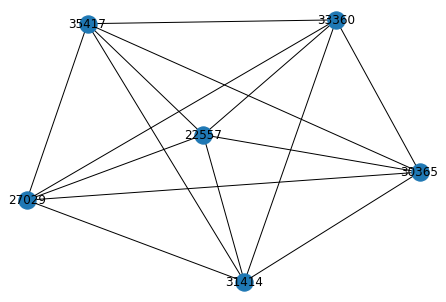

In [152]:
ego = nx.ego_graph(G_bidder, 22557) # ego network of the node
nx.draw(ego, with_labels=True)

In [114]:
#Lista anni
lista_unique_year=[]
for i in Pallottola['Date']:
    lista_unique_year.append(i.year)
insieme_year=set(lista_unique_year)
insieme_year

{1980,
 1982,
 1983,
 1984,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021}

In [112]:
newDict={}
for (kind, value) in dic.items():
   # Check if key is even then add pair to new dictionary
    if kind == 'Bidder':
        newDict[kind] = value

In [326]:
from tqdm.notebook import tqdm
for anno in tqdm(insieme_year):
    locals()["SG_"+str(anno)]=nx.Graph([(u,v,d) for u,v,d in G_bidder.edges(data=True) if pd.to_datetime(d['date']).year==anno])

  0%|          | 0/40 [00:00<?, ?it/s]

In [352]:
nx.info(SG_2018)

'Name: \nType: Graph\nNumber of nodes: 3440\nNumber of edges: 13548\nAverage degree:   7.8767'

In [346]:
edges=[]
nodes=[]
avg_degree=[]
for anno in insieme_year:
    edges.append(locals()["SG_"+str(anno)].number_of_edges())
    nodes.append(locals()["SG_"+str(anno)].number_of_nodes())
    avg_degree.append(2*locals()["SG_"+str(anno)].number_of_edges()/(locals()["SG_"+str(anno)].number_of_nodes()+1))

<AxesSubplot:>

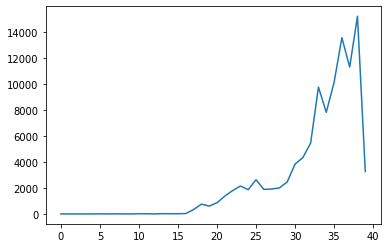

In [347]:
pd.Series(edges).plot()

Utile vedere ammontare denaro investito in gruppi >=2 e ammontare denaro quando hai solo un investitore - la domanda che ci siamo posti è un problema? Se un investitore partecipa da solo in 20 round significa che ti stai collegando ad uno con una certa expertise. Se investi con qualcuno che è sempre stato insieme a big player e poi ci investi da solo puoi scoprire se ha davvero la stoffa (è un follower o capisce bene gli investimenti da solo?). Invece se investi con qualcuno che ha sempre trovato deal da solo puoi giudicare bene quanto sia abile. 

Investitori che anticipano il trend e capiscono ottime opportunità o investitori hub che investono in cose medio buone che ne cambiano il destino perché si portano dietro altri investitori.

<b>Network direzionato</b> in cui punti tutti quelli che hanno investito in quell'azienda prima di te, per fare in modo di catturare quelli che hanno partecipato da soli ma che poi sono stati seguiti parecchio. Lo vedi con degree coming in elevato vs degree coming out basso. 

<AxesSubplot:>

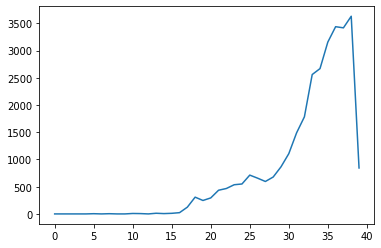

In [348]:
#Hai eliminato i lupi solitari
pd.Series(nodes).plot()

<AxesSubplot:>

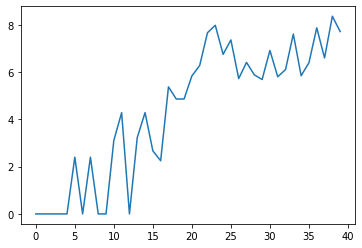

In [349]:
#Non hai contato lupi solitari, in teoria è inflazionato
pd.Series(avg_degree).plot()

## Degree centrality

Nei label degli edges potremmo mettere con quanti investitori sei collegato durante quel round, per capire quanto contribuisce al tuo degree

In [587]:
G_single = nx.Graph()
for u,v,data in G_bidder.edges(data=True):
    if data['m_raised']==np.nan:
        w=np.nan
    else:
        w = data['m_raised']*(1/((1/data['number'])+1))*(1/data['number']) if 'm_raised' in data else np.nan
    if G_single.has_edge(u,v):
        G_single[u][v]['weight'] += w
    else:
        G_single.add_edge(u, v, weight=w)

In [590]:
for u,v,data in G_single.edges(data=True):
    data['weight']=np.log(data['weight'])

In [566]:
nx.info(G_single)

'Name: \nType: Graph\nNumber of nodes: 14363\nNumber of edges: 85385\nAverage degree:  11.8896'

Necessario ricreare network con un solo collegamento pesato invece che tanti, con anche feature che ti dice sum(money_raised * number)

Nel passare a grafo singolo dobbiamo stare attenti al fatto che non è dinamico quindi se dobbiamo filtrare per anno o filtrare per round allora dobbiamo farlo sul multigrafo e poi trasformarlo in grafo (avrebbe anche senso filtrare per round per vedere a diversi stage di investimento come cambiano i rapporti tra investitori)

In [596]:
centrality_pagerank = nx.pagerank(G_single)

PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')

In [595]:
centrality_eigenvector_2=nx.eigenvector_centrality_numpy(G_single, max_iter=100, tol=1e-06, weight='weight')

ArpackNoConvergence: ARPACK error -1: No convergence (101 iterations, 0/1 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]

(array([3.0000e+00, 1.2000e+01, 1.7200e+02, 6.1700e+02, 3.7080e+03,
        1.6011e+04, 2.2633e+04, 2.5575e+04, 9.2340e+03, 5.8000e+02]),
 array([ 5.35538657,  6.9258631 ,  8.49633964, 10.06681618, 11.63729272,
        13.20776925, 14.77824579, 16.34872233, 17.91919887, 19.4896754 ,
        21.06015194]),
 <BarContainer object of 10 artists>)

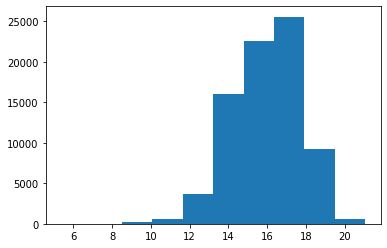

In [591]:
lista_utilissima=[]
for u,v,data in G_single.edges(data=True):
    lista_utilissima.append(data['weight'])
plt.hist((lista_utilissima))

In [572]:
G_single.edges(data=True)

EdgeDataView([(22557, 27029, {'weight': 1408609.4208333334}), (22557, 30365, {'weight': 1408609.4208333334}), (22557, 31414, {'weight': 1408609.4208333334}), (22557, 33360, {'weight': 1408609.4208333334}), (22557, 35417, {'weight': 1408609.4208333334}), (27029, 30365, {'weight': 1408609.4208333334}), (27029, 31414, {'weight': 1408609.4208333334}), (27029, 33360, {'weight': 1408609.4208333334}), (27029, 35417, {'weight': 1408609.4208333334}), (30365, 31414, {'weight': 1408609.4208333334}), (30365, 33360, {'weight': 1408609.4208333334}), (30365, 35417, {'weight': 1408609.4208333334}), (31414, 33360, {'weight': 1408609.4208333334}), (31414, 35417, {'weight': 1408609.4208333334}), (33360, 35417, {'weight': 1408609.4208333334}), (22558, 22647, {'weight': 8061498.587954546}), (22558, 22920, {'weight': 7109789.035454546}), (22558, 26048, {'weight': 8061498.587954546}), (22558, 26356, {'weight': 7109789.035454546}), (22558, 29736, {'weight': 7109789.035454546}), (22558, 34215, {'weight': 71097

In [569]:
centrality_eigenvector

{22557: 6.310486019737406e-20,
 27029: 6.310486019737406e-20,
 30365: 6.310486019737406e-20,
 31414: 6.310486019737406e-20,
 33360: 6.310486019737406e-20,
 35417: 6.310486019737406e-20,
 22558: 0.0023477148095392827,
 22647: 0.0023477148095392827,
 22920: 0.0021468066776587826,
 26048: 0.010765039636103327,
 26356: 0.04886707121426209,
 29736: 0.010494752280144732,
 34215: 0.09934821778020371,
 35495: 0.002890909411624327,
 38533: 0.009417683547723585,
 39358: 0.0021465423493029815,
 39917: 0.00376373211350081,
 38927: 0.0182226985029849,
 22560: 0.008203957348689438,
 24133: 0.024915710650384757,
 25501: 0.0891324095589172,
 28009: 0.023609745911343637,
 28066: 0.08277598907987382,
 31987: 0.01954112995056853,
 32246: 0.05992131374854361,
 34306: 0.021589827759668438,
 34462: 0.16319731926665487,
 35416: 0.019067480611311173,
 35531: 0.11744691380681387,
 39442: 0.11419563909021567,
 22561: 0.014289438105480027,
 26524: 0.024108923652210738,
 27370: 0.026074741123776644,
 29822: 0.005

In [490]:
centrality_betweenness=nx.betweenness_centrality(G_bidder, k=None, normalized=True, weight=None, endpoints=False, seed=None)

NetworkXNotImplemented: not implemented for multigraph type

In [507]:
nodes[nodes['kind']=='Bidder'].sort_values('Bidder_centrality_general',ascending=False)[10:20]

,Node,Country,Coo,kind,id,coo,lat,long,Bidder_centrality_general
23780,ARCH Venture Partners,United States,"(41.8755616, -87.6244212)",Bidder,23780,"[41.8755616, -87.6244212]",41.875562,-87.624421,0.035205
31662,Kleiner Perkins,United States,"(37.4519671, -122.1779927)",Bidder,31662,"[37.4519671, -122.1779927]",37.451967,-122.177993,0.034871
27914,F-Prime Capital,United States,"(42.3750997, -71.1056157)",Bidder,27914,"[42.3750997, -71.1056157]",42.375100,-71.105616,0.034147
33502,MPM Capital,United States,"(42.3750997, -71.1056157)",Bidder,33502,"[42.3750997, -71.1056157]",42.375100,-71.105616,0.032030
34215,Novartis Venture Fund,Switzerland,"(47.5581077, 7.5878261)",Bidder,34215,"[47.5581077, 7.5878261]",47.558108,7.587826,0.031863
34228,Novo Holdings,Denmark,"(55.6867243, 12.5700724)",Bidder,34228,"[55.6867243, 12.5700724]",55.686724,12.570072,0.031696
30431,InterWest Partners,United States,"(37.4519671, -122.1779927)",Bidder,30431,"[37.4519671, -122.1779927]",37.451967,-122.177993,0.031529
25356,Canaan Partners,United States,"(37.4519671, -122.1779927)",Bidder,25356,"[37.4519671, -122.1779927]",37.451967,-122.177993,0.030470
33865,New Leaf Venture Partners,United States,"(40.7127281, -74.0060152)",Bidder,33865,"[40.7127281, -74.0060152]",40.712728,-74.006015,0.030303
23339,Alta Partners,United States,"(37.7790262, -122.4199061)",Bidder,23339,"[37.7790262, -122.4199061]",37.779026,-122.419906,0.029523


In [480]:
nodes.iloc[22576]

Node                             10XF
Country                           NaN
Coo                               NaN
kind                           Bidder
id                              22576
coo                               NaN
lat                               NaN
long                              NaN
Bidder_centrality_general    0.000223
Name: 22576, dtype: object

In [500]:
for key,value in centrality_general.items():
    nodes.at[nodes[nodes['id']==key].index[0],'Bidder_centrality_general']=value

Interessante <b>comparare degree centrality con eigenvector centrality</b>: nella eigenvector tu vedi l'effetto di amici potenti (con alto degree). Ci sono modi per calcolare centrality in network pesati non direzionati? Possiamo così pesare ciascun nodo con ammontare investimento. Quanto sei centrale rispetto al denaro e non alle persone o una combinazione delle due. <br>
<b> Betweenness centrality </b> : quanto sei ponte di collegamento tra mondi diversi

In [497]:
nodes['Bidder_centrality_general']

''

In [469]:
for nodes.at[nodes[nodes['id']==2200].index[0],'Bidder_centrality_general']=np.nan

## Memo per la prossima volta: plottare distribuzione del degree di ciascun anno

## Clustering coefficient

Quanti sono i link presenti nel grafo sui link potenziali

In [382]:
lista_utilissima=[]
for i in insieme_year:
    if i>=2000 and i<2021:
        lista_utilissima.append(i)

In [375]:
lista_utilissima

[2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020]

Average degree rimane uguale ma il numero di nodi aumenta quindi density diminuisce

<AxesSubplot:>

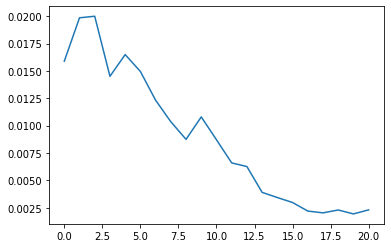

In [383]:
density_anno=[]
for anno in lista_utilissima:
    density_anno.append(nx.density(locals()["SG_"+str(anno)]))
pd.Series(density_anno).plot()                                      

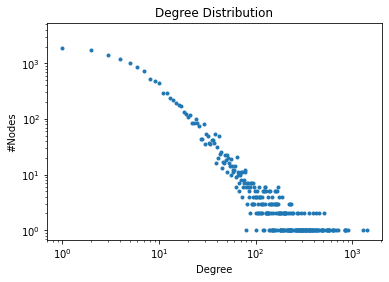

In [387]:
hist = nx.degree_histogram(G_bidder)
    
plt.plot(range(0, len(hist)), hist, ".")
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()
plt.show()

In [389]:
G_weighted = nx.Graph()
for u,v,data in G_bidder.edges(data=True):
    w = data['weight'] if 'weight' in data else 1.0
    if G.has_edge(u,v):
        G_weighted[u][v]['weight'] += w
    else:
        G_weighted.add_edge(u, v, weight=w)

TypeError: edges() got an unexpected keyword argument 'data'

Scontare i legami nel grafo rispetto al tempo, con una sorta di weight decay. 
Ricordati che per come è costruito il grafo adesso se due investitori investono nella stessa company a stage diversi non hanno un collegamento, per cui il degree tiene conto di questo. Puoi comunque tentare di capire se ci sono investitori hub nel momento in cui studi il grafo bidder-target. Per questo motivo forse non ha senso cancellare i nodi che hanno degree pari a 0. Eppure se vogliamo renderlo da multigraph a weighted graph questi nodi vengono cancellati (la funzione che segue fa questo, passiamo da 17953 a 14363)

Creiamo un grafo dove i link sono più generici - basta avere company insieme. Con questo possiamo capire chi sono questi lupi solitari. Cosa interessante è vedere nel tempo quanti siano gli investitori solitari per ogni anno

Dobbiamo tornare nel grafo bipartito, vedere quando hanno fatto investimenti e contarli per l'anno. Creiamo un network con self-loop

In [412]:
lista_utilissima=[]
for anno in insieme_year:
    for i in list(nx.degree(locals()["SG_"+str(anno)])):
        if i[1]==0:
            lista_utilissima.append(i[1])
    print(len(lista_utilissima))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [391]:
nx.info(G_weighted)

'Name: \nType: Graph\nNumber of nodes: 14363\nNumber of edges: 85385\nAverage degree:  11.8896'

In [384]:
plt.plot(nx.degree(G_bidder),nx.clustering(G_bidder))
plt.yscale("log")
plt.xscale("log")
plt.show()

NetworkXNotImplemented: not implemented for multigraph type